Contour plot of ln(evidence) for loss against number of layers\
for limited and not limited thickness

for below has no limit on max thickness\
above has a limits of punishishing the fitting of total thickness > 350 (for the varying slabs)

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
from sepObjective import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from CFitter import CFitter
import make_sim_data as msd
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))
%matplotlib inline
#%matplotlib noteboo

refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4
refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


In [2]:
maxLength = 350
def logp_extra(model, data=None):
    returns = 0
    if sum(model.structure.slabs()[1:-1,0])>maxLength:
        returns = -np.inf
    return returns

In [3]:

# simple structure
thicks_true = [10,120,100,130,10]
bs_true = [0,5,4.5,5,10]
roughs_true = [0,0,0,0,0]
# bs = [5,4.5,5]
# thicks = [120,100,130]
# roughs = [0,0,0]
bs = bs_true
thicks = thicks_true
roughs = roughs_true
loss = 1.
no_layers = len(bs)
no_layers = len(bs_true)
# no_layers = 3
layers = []
names = []
#names = ['layer1','layer2']
for i in range(no_layers):
    names.append('layer'+str(i))
for i in range(no_layers):
        sld = SLD(bs[i],name=names[i])
        layers.append(sld(thicks[i],roughs[i]))
structure = layers[0]
for layer in layers[1:]:
    structure|=layer
print("done")

done


done


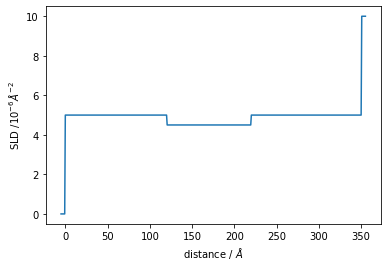

In [29]:
%matplotlib inline
figI = 0
# plt.figure(figI)
# figI+=1
plt.plot(*structure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
print("done")

In [5]:
resolution = 5.
model = ReflectModel(structure, bkg=3e-6, dq=resolution)

In [6]:
q = np.linspace(0.005, 0.3, 70)
losses = np.linspace(0.5,1.,4)#[0.5,0.,0.75,0.9,1]

# datas = []
objectives1 = []
# results1 = []
lnPosts1 = []
structures1 = []
lnEvidence1 = []

objectives2 = []
# results2 = []
lnPosts2 = []
structures2 = []
lnEvidence2 = []

for loss in losses:
    R = model(q, x_err=resolution)*loss
    sim_dR = msd.main(sim_q=q,sim_R=R)*10 # was sim_R=R*loss, double counting loss
    data = Data1D(data=(q,R,sim_dR))
#     datas.append(data)
    for i in range(1,5):
        print("\nloss:",loss,"n layers:", i)
        objective = gO(data, i, logpExtra=logp_extra)
        fitter = CFitter(objective)
        DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
        DNSampler.run_nested(dlogz_init=0.05)#0.01)
        result = DNSampler.results
        objectives1.append(objective)
        lnEvidence = result["logz"][-1]
        print("thickness limited lnEvidence:",lnEvidence)
        lnEvidence1.append(lnEvidence)

        objective = gO(data, i)
        fitter = CFitter(objective)
        DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
        DNSampler.run_nested(dlogz_init=0.05)#0.01)
        result = DNSampler.results
        objectives2.append(objective)
        lnEvidence = result["logz"][-1]
        print("lnEvidence:",lnEvidence)
        lnEvidence2.append(lnEvidence)



csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
loss: 0.5 n layers: 1


20576it [04:35, 74.68it/s, batch: 9 | bound: 63 | nc: 1 | ncall: 62641 | eff(%): 32.847 | loglstar: -22022.125 < -22015.885 < -22016.256 | logz: -22028.175 +/-  0.204 | stop:  0.992]   


thickness limited lnEvidence: -22028.153704017514


20457it [04:33, 74.82it/s, batch: 9 | bound: 62 | nc: 1 | ncall: 62398 | eff(%): 32.785 | loglstar: -22022.092 < -22015.886 < -22016.390 | logz: -22028.152 +/-  0.204 | stop:  0.981]   


lnEvidence: -22028.184688274174
loss: 0.5 n layers: 2


32785it [09:45, 55.98it/s, batch: 8 | bound: 169 | nc: 5 | ncall: 152711 | eff(%): 21.469 | loglstar: -21396.207 < -21388.105 < -21388.168 | logz: -21411.484 +/-  0.278 | stop:  0.957]  


thickness limited lnEvidence: -21411.499726942773


24969it [06:29, 64.16it/s, batch: 7 | bound: 128 | nc: 5 | ncall: 117417 | eff(%): 21.265 | loglstar: -21395.895 < -21388.249 < -21390.041 | logz: -21411.127 +/-  0.277 | stop:  0.927]  


lnEvidence: -21411.130122513667
loss: 0.5 n layers: 3


28421it [10:45, 44.06it/s, batch: 6 | bound: 148 | nc: 2 | ncall: 136520 | eff(%): 20.818 | loglstar: -20776.925 < -20768.046 < -20770.508 | logz: -20799.227 +/-  0.323 | stop:  0.918]    


thickness limited lnEvidence: -20799.212681368404


30138it [12:06, 41.49it/s, batch: 6 | bound: 104 | nc: 3 | ncall: 195498 | eff(%): 15.416 | loglstar: -20779.374 < -20769.593 < -20771.789 | logz: -20803.462 +/-  0.328 | stop:  0.995]  


lnEvidence: -20803.32327289713
loss: 0.5 n layers: 4


36169it [12:08, 49.67it/s, batch: 7 | bound: 186 | nc: 5 | ncall: 160583 | eff(%): 22.524 | loglstar: -20687.378 < -20677.716 < -20678.000 | logz: -20710.242 +/-  0.327 | stop:  0.926]  


thickness limited lnEvidence: -20710.241902463604


28382it [10:00, 47.28it/s, batch: 6 | bound: 137 | nc: 2 | ncall: 125492 | eff(%): 22.617 | loglstar: -20686.645 < -20678.315 < -20681.129 | logz: -20710.595 +/-  0.331 | stop:  0.945]  


lnEvidence: -20710.614379519593
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
loss: 0.6666666666666666 n layers: 1


19206it [04:04, 78.42it/s, batch: 10 | bound: 52 | nc: 2 | ncall: 50230 | eff(%): 38.236 | loglstar: -8524.933 < -8518.814 < -8519.131 | logz: -8527.259 +/-  0.173 | stop:  0.974]     


thickness limited lnEvidence: -8527.26418299856


21101it [04:23, 80.05it/s, batch: 11 | bound: 54 | nc: 1 | ncall: 53044 | eff(%): 39.780 | loglstar: -8525.322 < -8518.814 < -8519.142 | logz: -8527.539 +/-  0.176 | stop:  0.901]     


lnEvidence: -8527.527221022197
loss: 0.6666666666666666 n layers: 2


21972it [05:47, 63.14it/s, batch: 7 | bound: 91 | nc: 2 | ncall: 89106 | eff(%): 24.658 | loglstar: -7080.246 < -7073.623 < -7075.466 | logz: -7092.652 +/-  0.252 | stop:  0.951]      


thickness limited lnEvidence: -7092.652657222519


22090it [05:58, 61.56it/s, batch: 7 | bound: 95 | nc: 2 | ncall: 91884 | eff(%): 24.041 | loglstar: -7080.189 < -7073.590 < -7074.710 | logz: -7092.594 +/-  0.252 | stop:  0.974]      


lnEvidence: -7092.5936011602935
loss: 0.6666666666666666 n layers: 3


32420it [26:57, 20.04it/s, batch: 8 | bound: 483 | nc: 19 | ncall: 681872 | eff(%):  4.755 | loglstar: -6973.752 < -6964.989 < -6965.125 | logz: -6987.773 +/-  0.270 | stop:  0.875]     


thickness limited lnEvidence: -6987.757049967671


33708it [26:27, 21.23it/s, batch: 8 | bound: 524 | nc: 14 | ncall: 696069 | eff(%):  4.843 | loglstar: -6974.044 < -6965.134 < -6967.413 | logz: -6987.743 +/-  0.265 | stop:  0.837]     


lnEvidence: -6987.740416257086
loss: 0.6666666666666666 n layers: 4


32693it [12:27, 43.76it/s, batch: 7 | bound: 324 | nc: 1 | ncall: 284048 | eff(%): 11.510 | loglstar: -6951.679 < -6942.173 < -6942.459 | logz: -6968.426 +/-  0.288 | stop:  0.926]     


thickness limited lnEvidence: -6968.409004941244


32935it [12:23, 44.27it/s, batch: 7 | bound: 304 | nc: 27 | ncall: 273400 | eff(%): 12.046 | loglstar: -6951.772 < -6942.221 < -6942.468 | logz: -6968.666 +/-  0.290 | stop:  0.919]     


lnEvidence: -6968.700627526253
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
loss: 0.8333333333333333 n layers: 1


21757it [03:52, 93.42it/s, batch: 9 | bound: 67 | nc: 4 | ncall: 65087 | eff(%): 33.428 | loglstar: -2820.874 < -2814.526 < -2814.991 | logz: -2826.891 +/-  0.204 | stop:  0.932]     


thickness limited lnEvidence: -2826.8961462523416


23813it [04:22, 90.60it/s, batch: 10 | bound: 73 | nc: 1 | ncall: 69520 | eff(%): 34.253 | loglstar: -2821.348 < -2814.520 < -2814.948 | logz: -2826.732 +/-  0.203 | stop:  0.983]    


lnEvidence: -2826.7346983527063
loss: 0.8333333333333333 n layers: 2


25578it [05:40, 75.08it/s, batch: 9 | bound: 106 | nc: 4 | ncall: 102593 | eff(%): 24.932 | loglstar: -1284.503 < -1276.869 < -1278.092 | logz: -1294.460 +/-  0.239 | stop:  0.930]    


thickness limited lnEvidence: -1294.463309916167


19974it [04:16, 78.02it/s, batch: 7 | bound: 83 | nc: 2 | ncall: 82029 | eff(%): 24.350 | loglstar: -1283.482 < -1276.866 < -1278.038 | logz: -1294.553 +/-  0.242 | stop:  0.997]      


lnEvidence: -1294.5262220939194
loss: 0.8333333333333333 n layers: 3


26024it [09:21, 46.34it/s, batch: 8 | bound: 190 | nc: 1 | ncall: 196675 | eff(%): 13.232 | loglstar: -1274.442 < -1266.024 < -1268.221 | logz: -1287.911 +/-  0.261 | stop:  0.908]    


thickness limited lnEvidence: -1287.9091175952526


32893it [15:12, 36.06it/s, batch: 7 | bound: 301 | nc: 3 | ncall: 363556 | eff(%):  9.048 | loglstar: -1274.446 < -1265.675 < -1265.714 | logz: -1287.761 +/-  0.262 | stop:  0.928]    


lnEvidence: -1287.7645545727062
loss: 0.8333333333333333 n layers: 4


32824it [21:52, 25.01it/s, batch: 7 | bound: 399 | nc: 1 | ncall: 419448 | eff(%):  7.826 | loglstar: -1275.820 < -1265.703 < -1265.920 | logz: -1289.886 +/-  0.268 | stop:  0.963]       


thickness limited lnEvidence: -1289.8879661963538


34172it [21:25, 26.58it/s, batch: 7 | bound: 402 | nc: 10 | ncall: 380108 | eff(%):  8.990 | loglstar: -1275.954 < -1265.727 < -1265.863 | logz: -1289.879 +/-  0.268 | stop:  0.883]    


lnEvidence: -1289.860225072015
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
loss: 1.0 n layers: 1


20891it [04:36, 75.47it/s, batch: 9 | bound: 65 | nc: 2 | ncall: 63754 | eff(%): 32.768 | loglstar: -1811.430 < -1805.361 < -1805.966 | logz: -1818.388 +/-  0.211 | stop:  0.960]     


thickness limited lnEvidence: -1818.411075758853


21945it [04:35, 79.71it/s, batch: 9 | bound: 68 | nc: 1 | ncall: 65816 | eff(%): 33.343 | loglstar: -1811.756 < -1805.358 < -1805.901 | logz: -1818.242 +/-  0.209 | stop:  0.988]     


lnEvidence: -1818.2508356726373
loss: 1.0 n layers: 2


22244it [04:19, 85.80it/s, batch: 9 | bound: 75 | nc: 2 | ncall: 72006 | eff(%): 30.892 | loglstar: 78.750 < 85.931 < 84.990 | logz: 72.976 +/-  0.200 | stop:  0.937]                


thickness limited lnEvidence: 72.97116284294752


24091it [04:34, 87.68it/s, batch: 9 | bound: 77 | nc: 8 | ncall: 74358 | eff(%): 32.399 | loglstar: 78.483 < 85.950 < 85.130 | logz: 72.275 +/-  0.205 | stop:  0.940]                


lnEvidence: 72.29432028604006
loss: 1.0 n layers: 3


21834it [06:11, 58.77it/s, batch: 7 | bound: 121 | nc: 13 | ncall: 121221 | eff(%): 18.012 | loglstar: 100.593 < 108.231 < 106.226 | logz: 91.161 +/-  0.229 | stop:  0.963]          


thickness limited lnEvidence: 91.13733292229811


25376it [07:47, 54.30it/s, batch: 8 | bound: 153 | nc: 1 | ncall: 153911 | eff(%): 16.487 | loglstar: 99.940 < 108.273 < 106.919 | logz: 91.098 +/-  0.227 | stop:  0.931]            


lnEvidence: 91.11035384560891
loss: 1.0 n layers: 4


26396it [2:12:30,  3.32it/s, batch: 8 | bound: 3235 | nc: 27 | ncall: 3028136 | eff(%):  0.872 | loglstar: 99.217 < 107.954 < 105.967 | logz: 89.601 +/-  0.234 | stop:  0.904]       


thickness limited lnEvidence: 89.57239055379468


20579it [3:20:31,  1.71it/s, batch: 6 | bound: 3400 | nc: 21 | ncall: 3270491 | eff(%):  0.629 | loglstar: 100.329 < 108.053 < 106.129 | logz: 89.539 +/-  0.238 | stop:  0.927]          


lnEvidence: 89.53605708217408


In [11]:
f=open("dLVsNLLnEvidence.txt","w+")
f.write("limited max thickness ln(evidence):\n")
for lnEvidence in lnEvidence1:
    f.write(str(lnEvidence))
f.write("\nnot limited max thickness ln(evidence):\n")
for lnEvidence in lnEvidence2:
    f.write(str(lnEvidence))
f.close()

In [2]:
def toArray(line,n,m=-1):
    array=line.reshape((n,m))
    return array

def meshGraph(line, xs, ys, xlabel="", ylabel="", title="",printType="", figI=0):
    #resolutions = [1.,3.,7.,9.]
    #dRScaleBys = [5,10,15,20]
    ha_s = ["left", "center", "center", "right"]

    print(printType,line)#"not thickness limited ln(post):",line)
    n, m = len(xs), len(ys)
    zs = toArray(line,m,n)
#     zs= np.array(lnPosts1).reshape(len(xs), len(ys))
    plt.figure(figI)
    figI+=1
    plt.contour(xs,ys,zs,alpha=0.5);
    plt.contourf(xs,ys,zs,alpha=0.3);
    plt.colorbar();
    for i in range(len(xs)):
        for j in range(len(ys)):
            plt.scatter(xs[i],ys[j],c="red",marker="x");
            ha = ha_s[i]
            plt.annotate("%.3f"%zs[j][i],(xs[i],ys[j]),
                        horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
    # for x in dRScaleBys:
    #     for y in resolutions:
    #         plt.scatter(x,y,c="red",marker="x");
    plt.ylabel(ylabel);#"dq");
    plt.xlabel(xlabel);#"dR scaled by");
    plt.title(title);#"thickness limited contour plot of ln(evidence) for dq vs dR scaled by");
    plt.tight_layout();
    plt.show();
    return figI

# Corrected

thickness limited contour plot of ln(evidence) for layers vs loss [-22028.15370402 -21411.49972694 -20799.21268137 -20710.24190246
  -8527.264183    -7092.65265722  -6987.75704997  -6968.40900494
  -2826.89614625  -1294.46330992  -1287.9091176   -1289.8879662
  -1818.41107576     72.97116284     91.13733292     89.57239055]


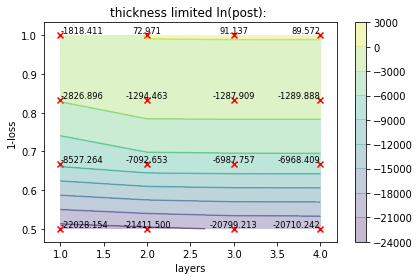

not thickness limited contour plot of ln(evidence) for layers vs loss [-22028.18468827 -21411.13012251 -20803.3232729  -20710.61437952
  -8527.52722102  -7092.59360116  -6987.74041626  -6968.70062753
  -2826.73469835  -1294.52622209  -1287.76455457  -1289.86022507
  -1818.25083567     72.29432029     91.11035385     89.53605708]


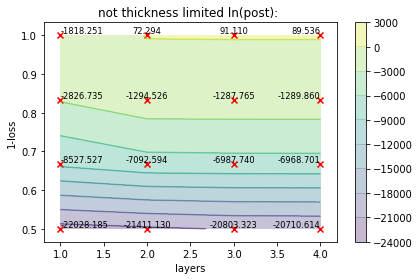

1

In [4]:
line = np.array([-22028.153704017514, -21411.499726942773, -20799.212681368404, -20710.241902463604, -8527.26418299856, -7092.652657222519, -6987.757049967671, -6968.409004941244, -2826.8961462523416, -1294.463309916167, -1287.9091175952526, -1289.8879661963538, -1818.411075758853, 72.97116284294752, 91.13733292229811, 89.57239055379468])
nLayers = [i for i in range(1,5)]
losses = np.linspace(0.5,1.,4)
ylabel="1-loss"
xlabel="layers"
title="thickness limited contour plot of ln(evidence) for layers vs loss"
meshGraph(line, nLayers, losses, xlabel, ylabel,"thickness limited ln(evidence): ", title)

line=np.array([-22028.184688274174, -21411.130122513667, -20803.32327289713, -20710.614379519593, -8527.527221022197, -7092.5936011602935, -6987.740416257086, -6968.700627526253, -2826.7346983527063, -1294.5262220939194, -1287.7645545727062, -1289.860225072015, -1818.2508356726373, 72.29432028604006, 91.11035384560891, 89.53605708217408])
title="not thickness limited contour plot of ln(evidence) for layers vs loss"
meshGraph(line, nLayers, losses, xlabel, ylabel,"not thickness limited ln(evidence): ", title)


# previous version

[-22028.153704017514, -21411.499726942773, -20799.212681368404, -20710.241902463604, -8527.26418299856, -7092.652657222519, -6987.757049967671, -6968.409004941244, -2826.8961462523416, -1294.463309916167, -1287.9091175952526, -1289.8879661963538, -1818.411075758853, 72.97116284294752, 91.13733292229811, 89.57239055379468]


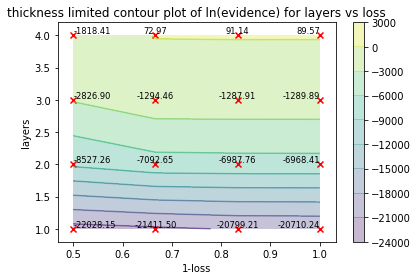

[-22028.184688274174, -21411.130122513667, -20803.32327289713, -20710.614379519593, -8527.527221022197, -7092.5936011602935, -6987.740416257086, -6968.700627526253, -2826.7346983527063, -1294.5262220939194, -1287.7645545727062, -1289.860225072015, -1818.2508356726373, 72.29432028604006, 91.11035384560891, 89.53605708217408]


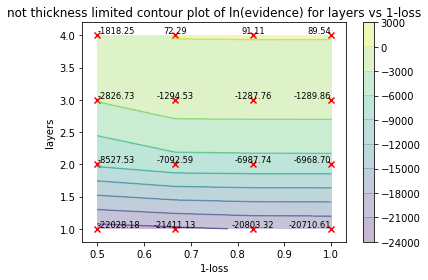

Wall time: 728 ms


In [62]:
%%time

ha_s = ["left", "center", "center", "right"]

print(lnEvidence1)
lenLosses = len(losses)
nLayers = [i for i in range(1,5)]

z = np.array(lnEvidence1).reshape((-1,lenLosses))

# plt.figure(figI);
# figI+=1
plt.contour(losses,nLayers,z,alpha=0.5);
plt.contourf(losses,nLayers,z,alpha=0.3);
plt.colorbar();
for i in range(len(losses)):#x in losses:
    for j in range(len(nLayers)): #y in nLayers:
        plt.scatter(losses[i],nLayers[j],c="red",marker="x");
        ha = ha_s[i]
        plt.annotate("%.2f"%z[j][i],(losses[i],nLayers[j]),
                    horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
plt.ylabel("layers");
plt.xlabel("1-loss");
plt.title("thickness limited contour plot of ln(evidence) for layers vs loss");
plt.tight_layout();
plt.show();
#--------

print(lnEvidence2)
lenLosses = len(losses)
nLayers = [i for i in range(1,5)]

z = np.array(lnEvidence2).reshape((-1,lenLosses))

# plt.figure(figI);
# figI+=1
plt.contour(losses,nLayers,z,alpha=0.5);
plt.contourf(losses,nLayers,z,alpha=0.3);
plt.colorbar();
# for x in losses:
#     for y in nLayers:
#         plt.scatter(x,y,c="red",marker="x");

for i in range(len(losses)):#x in losses:
    for j in range(len(nLayers)): #y in nLayers:
        plt.scatter(losses[i],nLayers[j],c="red",marker="x");
        ha = ha_s[i]
        plt.annotate("%.2f"%z[j][i],(losses[i],nLayers[j]),
                    horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
plt.ylabel("layers");
plt.xlabel("1-loss");
plt.title("not thickness limited contour plot of ln(evidence) for layers vs 1-loss");
plt.tight_layout();
plt.show();

In [64]:
# for objective1,objective2 in zip(objectives1,objectives2):
#     plt.figure(figI)
#     figI+=1

# #     plt.subplot(2,2,1).set_title("data plotted for limited max thickness")
#     fig, ax = objective1.plot()
#     plt.figure(figI)
#     figI+=1
# #     plt.subplot(2,2,2).set_title("structure plotted for limited max thickness")
#     plt.plot(*objective1.model.structure.sld_profile())
#     plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
#     plt.xlabel('distance / $\AA$');
#     plt.figure(figI)
#     figI+=1

# #     plt.subplot(2,2,3).set_title("data plotted for limited max thickness")
#     fig, ax = objective2.plot()
#     plt.figure(figI)
#     figI+=1
# #     plt.subplot(2,2,4).set_title("structure plotted for limited max thickness")
#     plt.plot(*objective2.model.structure.sld_profile())
#     plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
#     plt.xlabel('distance / $\AA$');

# #     plt.tight_layout();
